# Including
* Single-Particle Hofstadter Matrix
* Essentials First Band Approximation Functions

In [71]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Model Parameters

In [2]:
Nx=8; Ny=10; N=Nx*Ny; p=1; q=Ny; cut_off=Nx;
PN=[0,1,2,3];
U=2;
println("Magnetic flux per unit-cell:",p//q,", Number of flux quanta:",Nx)

Magnetic flux per unit-cell:1//10, Number of flux quanta:8


# Sub-Space Operators of Single-Particle Space

In [3]:
#@doc get_sp_op

In [4]:
sp_basis = NLevelBasis(N)
periodicity = 0
sp_matrix = Hofstadter_SP(Nx, Ny, p/q, periodicity);

In [5]:
H1 = get_sp_op(sp_basis, N, sp_matrix);

In [6]:
using LinearAlgebra
eigenenergies(dense(H1)) == eigvals(sp_matrix)
show(stdout, "text/plain", eigvals(sp_matrix))

80-element Vector{Float64}:
 -3.420053641408173
 -3.4200536414081695
 -3.4200153004721425
 -3.420015300472141
 -3.4200153004721403
 -3.4200153004721376
 -3.419976950201189
 -3.419976950201185
 -2.35230282337433
 -2.35230282337433
 -2.351552346547092
 -2.351552346547092
 -2.351552346547092
 -2.351552346547091
 -2.3507988713924597
 -2.3507988713924592
 -1.4776985043449289
 -1.477698504344928
 -1.4715820869198095
 -1.4715820869198095
 -1.4715820869198086
 -1.4715820869198086
 -1.465283441759455
 -1.4652834417594534
 -0.7570660026277768
 -0.7570660026277768
 -0.7258326903745499
 -0.7258326903745488
 -0.7258326903745481
 -0.7258326903745479
 -0.6882911202826466
 -0.6882911202826453
 -0.3458904742074982
 -0.3458904742074975
 -0.28514903651549856
 -0.28514903651549783
 -0.2851490365154978
 -0.2851490365154963
 -0.2241084340414668
 -0.22410843404146663
  0.22410843404146696
  0.22410843404146735
  0.2851490365154943
  0.2851490365154979
  0.2851490365154984
  0.2851490365154986
  0.34589047420

In [7]:
sub_states = get_sub_states(H1, cut_off);

In [8]:
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [9]:
H1_sub = get_subspace_op(H1, P, Pt);

In [10]:
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

# Hubbard Interaction in The Sub-Space

In [11]:
states_mb = bosonstates(basis_sub, PN) 
basis_mb = ManyBodyBasis(basis_sub, states_mb);

In [12]:
H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub);
eigenenergies(dense((H1_MB'+H1_MB)/2))

165-element Vector{Float64}:
 -10.260160924224516
 -10.260160924224513
 -10.2601609242245
 -10.260160924224488
 -10.260122583288487
 -10.260122583288485
 -10.260122583288481
 -10.260122583288478
 -10.260122583288478
 -10.260122583288476
 -10.260122583288474
 -10.260122583288474
 -10.260122583288474
   ⋮
  -6.839953900402378
  -6.839953900402372
  -6.839953900402369
  -3.420053641408169
  -3.4200536414081673
  -3.420015300472141
  -3.420015300472139
  -3.4200153004721385
  -3.4200153004721363
  -3.419976950201187
  -3.419976950201185
   0.0

In [13]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme");

In [14]:
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN)
H_Int = Hubbard_Interaction(basis_cut_sp, basis_cut_mb, P, Pt, cut_off);

# Total Hamiltonian with Impurity Potential

In [15]:
H1cut = SparseOperator(basis_cut_mb)
H1cut.data = H1_MB.data

number_mb_list_operators = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)

function get_total_H(V, imp_site, number_mb_list_operators, H1cut, H_Int)
    V_imp = V * number_mb_list_operators[imp_site]
    H_totall = H1cut + H_Int + V_imp
    return H_totall
end

get_total_H (generic function with 1 method)

In [16]:
#imp_site = 44
imp_site = 1
V = 4

H_total_imp = get_total_H(V, imp_site, number_mb_list_operators, H1cut, H_Int)
# Impurity is equalt to zero
H_total = get_total_H(0, imp_site, number_mb_list_operators, H1cut, H_Int)

eigenenergies(dense((H_total+H_total')/2))

165-element Vector{Float64}:
 -10.259932886485377
 -10.25993288648536
 -10.259901993554317
 -10.259901993554303
 -10.259900232224384
 -10.259900232224384
 -10.25990023222438
 -10.25990023222438
 -10.259850864410987
 -10.259850864410984
 -10.259850864410982
 -10.259850864410977
 -10.259849006190189
   ⋮
  -6.737768195736943
  -6.73776819573694
  -6.737592682681311
  -3.420053641408169
  -3.4200536414081673
  -3.420015300472141
  -3.420015300472139
  -3.4200153004721385
  -3.4200153004721363
  -3.419976950201187
  -3.419976950201185
   0.0

# Exact Diagonalization

In [17]:
using DataFrames

E, V = eigenstates(dense((H_total_imp+dagger(H_total_imp))/2))
E0, V0 = eigenstates(dense((H_total+dagger(H_total))/2))

function get_energies(pn, E, V, basis)
    PN_Energies = Array{Float64}(undef, length(E), 2)
    for i in 1:length(E)
        PN_Energies[i] = round(expect(number(basis), V[i])) 
        PN_Energies[i,2] = E[i] 
    end
    
    # filter
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_energies (generic function with 1 method)

In [18]:
PN

4-element Vector{Int64}:
 0
 1
 2
 3

In [53]:
pn = 3.0

df = get_energies(pn, E, V, basis_cut_mb)
df_0 = get_energies(pn, E0, V0, basis_cut_mb)

# V \neq 0
filtered_energies = Matrix(df)[:,2]
# V = 0
filtered_energies_0 = Matrix(df_0)[:,2]

show(stdout,"text/plain", filtered_energies) #show all outputs

120-element Vector{Float64}:
 -10.259890368278562
 -10.259884355536741
 -10.25986451237834
 -10.259850884356046
 -10.259839167727387
 -10.259824249734962
 -10.259823526897184
 -10.222086796366424
 -10.222016263190625
 -10.219513235302076
 -10.217732415278814
 -10.199841575511723
 -10.1964634812048
 -10.196370276921028
 -10.193897972434375
 -10.18860962520194
 -10.187124685014215
 -10.187117377091933
 -10.186720279397347
 -10.183076329588463
 -10.182809071771732
 -10.181271453209527
 -10.18063253938977
 -10.180167831109154
 -10.175528903872728
 -10.175272705478266
 -10.174944755401096
 -10.171993940011001
 -10.167254547436375
 -10.164251522521695
 -10.163728078503045
 -10.163179883638065
 -10.162923289754177
 -10.16265781915025
 -10.162633162769872
 -10.157337248745867
 -10.15286710105754
 -10.152843232284175
 -10.152579613448632
 -10.150766859209643
 -10.14889866450043
 -10.147560425983405
 -10.14711748099153
 -10.142554852804857
 -10.142387363239065
 -10.139937499912401
 -10.135035512

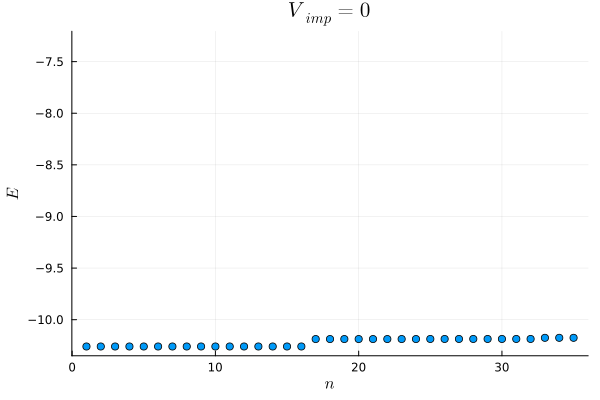

In [22]:
using Plots
using LaTeXStrings

Plots.plot(1:35, E0, seriestype=:scatter,xlabel=L"$n$",ylabel=L"$E$",title=L"$V_{imp}=0$",legend=false)
#ylims!((-7.20544,-7.20536)) # Onur hocanın makalesinde ki FIG1 için sınırlar
Plots.ylims!(( -10.35,-7.20536))

Allta ki fonksiyonun çalışması için, dizide ki filtre edilmiş parçacık sayısı her zaman en büyük değer de olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

In [54]:
function Restricted_Hubbard_States(states)
    number_of_states = length(filtered_energies)
    return states[1:number_of_states]
end

Restricted_Hubbard_States (generic function with 1 method)

In [55]:
r_hubbard_states = Restricted_Hubbard_States(V)
r_hubbard_states_0 = Restricted_Hubbard_States(V0);

# Densities

In [56]:
# METHOD 1

NM_MB_Array_Storage = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb),N);
NM_MB_Matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb));
for m in 1:N
    for i in 1:length(basis_cut_mb)
        for j in 1:length(basis_cut_mb)
            #NM_MB_Matrix[i,j] = num_mb_list[m].data[i,j]
            NM_MB_Matrix[i,j] = number_mb_list_operators[m].data[i,j]
            # NOT: num_mb_list ile number_mb_list_operators bazları farklı ama içerikleri aynı!
        end
    end
    NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
end

In [57]:
BL = BR = basis_cut_mb
index_number_op = 4

T = NM_MB_Array_Storage[:,:,index_number_op]
Op = Operator(BL,BR,T)

index_eigen_states = 1

expect(Op, r_hubbard_states[index_eigen_states])
expect(Op, r_hubbard_states_0[index_eigen_states])

# METHOD 2
# DIKKAT: BURADA DENSITY'LER YANLIŞ GELİYOR! BUNU KULLANMA!
# expect(number_mb_list_operators[index_number_op],r_hubbard_states[index_eigen_states])

0.056147989239729724 - 4.389882615309532e-19im

<font size="4">
$\sum_{i} <\psi_j|n_i|\psi_j>, \quad \text{for a given j index}$
</font>

In [58]:
index_eig_states = 1

function get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states)
    Sum = 0
    expect_list = []
    for i in 1:N
        T = NM_MB_Array_Storage[:,:,i]
        Op = Operator(BL,BR,T)   
        Sum += expect(Op, r_hubbard_states[index_eig_states])
        push!(expect_list, expect(Op, r_hubbard_states[index_eig_states]))
    end
    return real(expect_list)
end

get_density_profiles (generic function with 1 method)

<font size="4">
    \begin{align*}
    \frac{N}{N_{\Phi}} &= \frac{3}{8}, \quad \text{In the Laughlin State: } \frac{N}{N_{\Phi}}=\frac{3}{6}=\frac{1}{2} => \text{There are 2 free quasi-particles.} \\
    &\text{So, added 2 flux in the lattice is mean that, +2 free quasi-particles.}
    \end{align*}
</font>

In [59]:
# AVERAGE (Nx=8; Ny=10; N=Nx*Ny; p=1; q=Ny; cut_off=Nx; PN=[0,1,2,3])

# Degeneracy in The Sub-Space for V \neq 0
Degeneracy = 7 
avg_density = zeros((Nx,Ny)) 
for index_eig_states in 1:Degeneracy
    avg_density += reshape(get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states),Nx,Ny)
end    
avg_density = avg_density / Degeneracy;

# Degeneracy in The Sub-Space for V = 0
# Degeneracy_0 = 16
# avg_density_0 = zeros((Nx,Ny))
# for index_eig_states in 1:Degeneracy_0
#     avg_density_0 += reshape(get_density_profiles(NM_MB_Array_Storage, r_hubbard_states_0, index_eig_states),Nx,Ny)
# end    
# avg_density_0 = avg_density_0 / Degeneracy_0;

# Degeneracy_0 => Örgüde sadece 2 quasi-parçacık boştayken geçerli dejenereliktir.
# Ancak bizim bakmak istediğimiz resim, bu parçacıklardan birisini pinlenmiş ve diğerinin ise boşta olmasıdır.

# Lattice and Minimum Distances

In [60]:
site_idx = range(1,Nx*Ny) 
lattice = reverse(OffsetArray(reshape(site_idx, (Ny,Nx)), 1:Ny, 1:Nx), dims=1)
coordinates = []
for x in 0:Nx-1
    for y in 0:Ny-1
        coordinates = [coordinates; x; y]
    end
end
coordinates = reshape(coordinates, (2, Nx*Ny)) |> transpose
lattice;

In [61]:
# Original Square Lattice used by Single-Particle Matrix
square_lattice(Nx,Ny)[1];   

In [62]:
# Ghost Sites
coordinates_top_left = hcat(coordinates[:,1].-Nx,coordinates[:,2].+Ny)
coordinates_top = hcat(coordinates[:,1],coordinates[:,2].+Ny)
coordinates_top_right = hcat(coordinates[:,1].+Nx,coordinates[:,2].+Ny)
coordinates_left = hcat(coordinates[:,1].-Nx,coordinates[:,2])
coordinates_right = hcat(coordinates[:,1].+Nx,coordinates[:,2])
coordinates_bottom_left = hcat(coordinates[:,1].-Nx,coordinates[:,2].-Ny)
coordinates_bottom = hcat(coordinates[:,1],coordinates[:,2].-Ny)
coordinates_bottom_right = hcat(coordinates[:,1].+Nx,coordinates[:,2].-Ny);
co_districts = [coordinates_top_left,coordinates_top,coordinates_top_right,coordinates_left,coordinates_right,coordinates,coordinates_bottom_left,coordinates_bottom,coordinates_bottom_right];

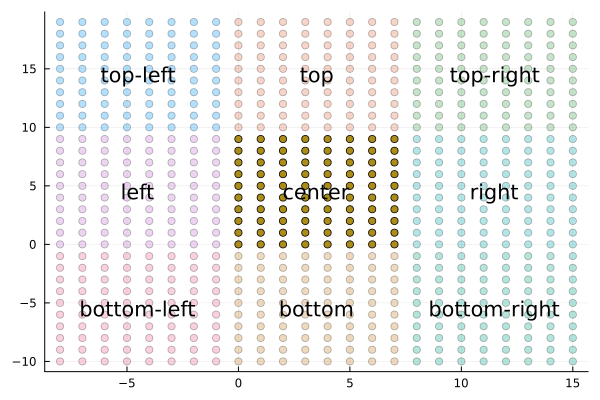

In [63]:
using Plots
center_x = (Nx-1)/2
center_y = (Ny-1)/2
scatter([coordinates_top_left[:,1]],[coordinates_top_left[:,2]],legend=false, alpha=0.3);annotate!( center_x-Nx, center_y+Ny, "top-left")
scatter!([coordinates_top[:,1]],[coordinates_top[:,2]], alpha=0.3);annotate!(center_x, center_y+Ny, "top")
scatter!([coordinates_top_right[:,1]],[coordinates_top_right[:,2]], alpha=0.3);annotate!(center_x+Nx, center_y+Ny, "top-right")
scatter!([coordinates_left[:,1]],[coordinates_left[:,2]], alpha=0.3);annotate!(center_x-Nx, center_y, "left")
scatter!([coordinates[:,1]], [coordinates[:,2]]);annotate!(center_x,center_y, "center")
scatter!([coordinates_right[:,1]],[coordinates_right[:,2]], alpha=0.3);annotate!(center_x+Nx, center_y, "right")
scatter!([coordinates_bottom_left[:,1]],[coordinates_bottom_left[:,2]], alpha=0.3);annotate!(center_x-Nx, center_y-Ny, "bottom-left")
scatter!([coordinates_bottom[:,1]],[coordinates_bottom[:,2]], alpha=0.3);annotate!(center_x, center_y-Ny, "bottom")
scatter!([coordinates_bottom_right[:,1]],[coordinates_bottom_right[:,2]], alpha=0.3);annotate!(center_x+Nx, center_y-Ny, "bottom-right")

In [64]:
# Distance Functions
function find_co(coordinates, p) # coordinates: Distrincts of Periodic Site
    x_co = coordinates[:,1]
    y_co = coordinates[:,2]
    x = hcat(x_co, y_co)[p, 1]
    y = hcat(x_co, y_co)[p, 2]
    return x, y
end

function distance(coordinates_p1, p1, coordinates_p2, p2)
    x2 = find_co(coordinates_p2, p2)[1]
    x1 = find_co(coordinates_p1, p1)[1]
    y2 = find_co(coordinates_p2, p2)[2]
    y1 = find_co(coordinates_p1, p1)[2]
    return sqrt( (x2 - x1)^2 + (y2 - y1)^2 )
end

distance (generic function with 1 method)

In [70]:
# Example of Disctance Function
coordinates_p1=coordinates_top_left
p1 = 1
coordinates_p2=coordinates
p2 = imp_site
distance(coordinates_p1, p1, coordinates_p2, p2)

12.806248474865697

# Minimum Distances of Equivalent Sites from Center Reference Site

In [50]:
# ref_coordinates = coordinates
# ref_site = 36
# distances = []
# min_distances = []

# PERIODIC
# for site_idx in 1:N 
#     for district in co_districts
#         push!(distances, distance(district, site_idx, ref_coordinates, ref_site))
#     end
#     push!(min_distances, minimum(distances))
# end
# radius_l = sort(min_distances);

# PERIODIC WITHOUT MINIMUM FUNCTION
# distances = []
# min_distances = []
# for site_idx in 1:N
#     for district in co_districts
#         push!(distances, distance(district, site_idx, ref_coordinates, ref_site))
#     end
# end
# show(stdout, "text/plain", unique(sort(distances)))

# Aynı Q_\rho değerleri üretmeyen yarı-çap listesi (DOĞRU YARI-ÇAPLAR)
# Yani, sadece Merkez içindeki siteler için minimum uzaklık hesapları
ref_coordinates = coordinates
ref_site = 36 # Site That Pinned
distances = []
for site_idx in 1:N 
    push!(distances, distance(coordinates, site_idx, ref_coordinates, ref_site))
end
radius_list = sort(unique(distances))

19-element Vector{Any}:
 0.0
 1.0
 1.4142135623730951
 2.0
 2.23606797749979
 2.8284271247461903
 3.0
 3.1622776601683795
 3.605551275463989
 4.0
 4.123105625617661
 4.242640687119285
 4.47213595499958
 5.0
 5.0990195135927845
 5.385164807134504
 5.656854249492381
 5.830951894845301
 6.4031242374328485

In [36]:
# radii = zeros(Nx, Ny, length(radius_l))
# for (index,value) in enumerate(radius_l)
#     radii[:,:,index] = reshape(radius_l.<=value, Nx, Ny)
# end
# radii;

In [37]:
# # BAZI RADIUS DEĞERLERİ ARADAN KAÇIYOR:
# Q_rhos = []
# for i in 1:length(radius_l)
#     push!(Q_rhos, sum( (3/70 .- avg_density) .* radii[:,:,i]))
# end
# #Q_rhos = unique!(Q_rhos)

# for (i,j) in enumerate(Q_rhos)
#     println("Radius=",round(radius_list[i],digits=2),"\t","Q_rho=",j)
# end

In [38]:
# Plots.plot(0:length(Q_rhos)-1, [Q_rhos], xlabel=L"\rho",ylabel=L"Q_{\rho}", guidefontsize=17,legend=false, linewidth=3)
# g(x)=3/7;x=0
# Plots.plot!(g, x, length(radius_list), line=(:dot,2), xlim=(0,6))
# # radius_list 0.1'den başlayınca değerler sapıtıyor çok çıkıyor!

# Density Plot and $Q_{\rho}$ Calculation with Equivalent Sites Conditions

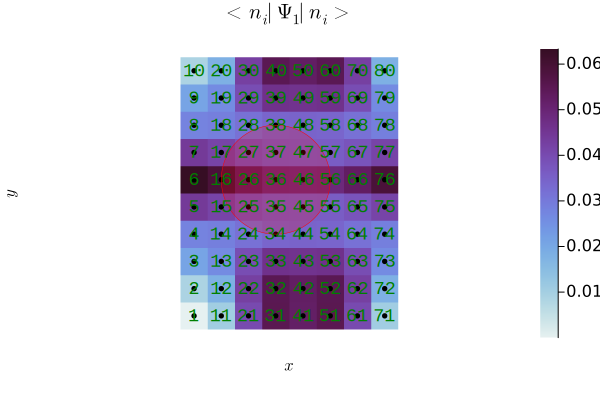

In [39]:
using LaTeXStrings

# Density Plot
Plots.heatmap(reshape(get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states), Nx, Ny)|>transpose, colormap=:dense)

# koordinatları 0 yerine 1'den başlatırsak heatmap ile uyumlu olur (.+1 operasyonu)
x_coordinates = coordinates[:,1] .+1
y_coordinates = coordinates[:,2] .+1
Plots.scatter!(x_coordinates, y_coordinates, label=false, aspect_ratio=1, showaxis = false, grid=false, markersize=3, c=:black, title=L"$<n_i|\Psi_1|n_i>$", xlabel=L"$x$",ylabel=L"$y$")

# Site Index
for i in 1:N
    p = annotate!(x_coordinates[i],y_coordinates[i], text("$i", :Courier, 10,:green))
end

# Circle
function circle_shape(h,k,r)
    beta = reverse(LinRange(0, 2*pi, 500))
    h .+ r*sin.(beta), k .+ r*cos.(beta)
end

# Bu örnekte imp_site=44 aslında 36.site'dır. Çünkü burada density en düşüktür!
center_x = x_coordinates[36]; center_y = y_coordinates[36]; radius = 2
plot!(circle_shape(center_x,center_y,radius), seriestype=[:shape], lw=0.5, c=:red, linecolor= :red, legend=false, fillalpha=0.2)

p

In [40]:
All_Coordinates = vcat(coordinates_top_left,coordinates_top,coordinates_top_right,coordinates_left,coordinates,coordinates_right,coordinates_bottom_left,coordinates_bottom,coordinates_bottom_right)
X_Coordinates = All_Coordinates[:,1]
Y_Coordinates =  All_Coordinates[:,2];

In [41]:
# Index and Coordinates of All Sites
idx_idx = []
for i in 1:9 
    for j in 1:Nx*Ny
        push!(idx_idx, j)
    end
end

# All_Coordinates_2, her bir Nx*Ny'lik sütun, sırasıyla bölge koordinatlarını soldan sağa ve aşağıdan yukarıya gösterir.
# Her bir bölgede 1'den Nx*Ny'ye site indekslemesi tüm siteler için yapılır.
All_Coordinates_2 = hcat(idx_idx,All_Coordinates);

In [42]:
# Example of Find Equivalent Site 
XX = -4 # 4 -> coordinates (X Coordinates of Center Distrinct Site)
YY = 19 # 9 -> coordinates (Y Coordinates of Center Distrinct Site)
Intersect = intersect(findall(x->x==XX, All_Coordinates[:,1]), findall(x->x==YY, All_Coordinates[:,2]))
Equivalent_Site = All_Coordinates_2[:,1][Intersect][1]

50

In [43]:
lattice

10×8 OffsetArray(::Matrix{Int64}, 1:10, 1:8) with eltype Int64 with indices 1:10×1:8:
 10  20  30  40  50  60  70  80
  9  19  29  39  49  59  69  79
  8  18  28  38  48  58  68  78
  7  17  27  37  47  57  67  77
  6  16  26  36  46  56  66  76
  5  15  25  35  45  55  65  75
  4  14  24  34  44  54  64  74
  3  13  23  33  43  53  63  73
  2  12  22  32  42  52  62  72
  1  11  21  31  41  51  61  71

In [44]:
function Get_Site_Idx(XX, YY)
    Intersect = intersect(findall(x->x==XX, All_Coordinates[:,1]), findall(x->x==YY, All_Coordinates[:,2]))
    Equivalent_Site = All_Coordinates_2[:,1][Intersect][1]
    return Equivalent_Site
end
Get_Site_Idx(-8, 10)

1

In [51]:
ref_district = coordinates # Center Distrinct
ref_site = 36 # V imp. site = 36

Ref_Site_X = ref_district[:,1][ref_site]
Ref_Site_Y = ref_district[:,2][ref_site]

# Hangi siteler, ilgili yarı-çap içerisinde şartını kontrol ediyoruz
function Inner_Sites(Radius)
    
    inner_sites = []
    
    for i in 1:Nx*Ny*9
        
        if (X_Coordinates[i] - Ref_Site_X)^2 + (Y_Coordinates[i] - Ref_Site_Y)^2 < (Radius+0.1)^2
            
            # Yarı-çap büyüdüğünde, periyodik noktalara sıçrayınca, "Get_Site_Idx" fonksiyonu ile eş-değer siteleri buluyoruz.
            push!(inner_sites, Get_Site_Idx(X_Coordinates[i], Y_Coordinates[i]))
        end
    end
    
    return inner_sites
end

Radius = 1
Inner_Sites(Radius)

5-element Vector{Any}:
 26
 35
 36
 37
 46

\begin{align*}
&Q_{\rho} = \sum_i \left(<n_i>_{V=0}-<n_i>_{V \neq 0} \right) \\
&<n_i>_{V=0} \approx \text{(Magnetic flux per unit-cell)} * \frac{N}{N_{\Phi}-1} = \frac{3}{70}
\end{align*}

In [52]:
density_list = []
density_list_2 = []
summ_list = []

for i in radius_list
    
    summ = 0

    for j in Inner_Sites(i)
        
        # r içindeki her bir sitenin ortalama yoğunluğu 
        push!(density_list, collect(Iterators.flatten((3/70 .- avg_density|>transpose)))[j])
        # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
        
        # aynı yoğunluklar gelirse sadece onların birisini tut
        density_list_2 = unique!(density_list)
        
        # her biri biricik ve her bir site için olan yoğunlukları topla
        summ = sum(density_list_2)
    end
    
    # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
    push!(summ_list, summ)
    println("Radius:",round(i,digits=3),"\t","Q_rho:",summ)
end

Radius:0.0	Q_rho:-0.0001809988352637279
Radius:1.0	Q_rho:-0.0016026968450921497
Radius:1.414	Q_rho:-0.003515264713778811
Radius:2.0	Q_rho:-0.006201362827066639
Radius:2.236	Q_rho:-0.01036457913630115
Radius:2.828	Q_rho:-0.008426883855778257
Radius:3.0	Q_rho:-0.010853119539609643
Radius:3.162	Q_rho:-0.009003867297589764
Radius:3.606	Q_rho:0.01741858429113617
Radius:4.0	Q_rho:0.01849435914994542
Radius:4.123	Q_rho:0.034647044705153174
Radius:4.243	Q_rho:0.07147707932219935
Radius:4.472	Q_rho:0.12707518359423692
Radius:5.0	Q_rho:0.25204624403037174
Radius:5.099	Q_rho:0.25204624403037174
Radius:5.385	Q_rho:0.2878617605120694
Radius:5.657	Q_rho:0.33794129536675155
Radius:5.831	Q_rho:0.39549471977386264
Radius:6.403	Q_rho:0.42857142857142805


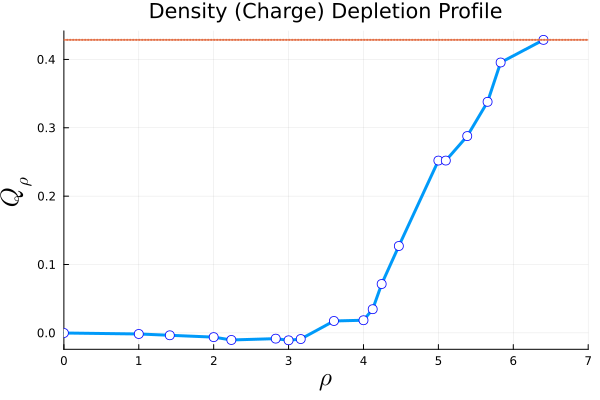

In [47]:
Plots.plot(radius_list, summ_list, xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Density (Charge) Depletion Profile", guidefontsize=17,legend=false, linewidth=3, xticks=0:1:12, yticks=0:0.10:0.46, m = (5, :white, stroke(1, :blue)))
g(x)=3/7;x=0
Plots.plot!(g, x, length(radius_list), line=(:dot,2), xlim=(0,7))

# Interpolation

In [ ]:
using CairoMakie

fig = Figure()
ax = Axis(fig[1,1], title="Average Density (Ground Degeneracy=$(Degeneracy))", xlabel=L"$x$", ylabel=L"$y$")
ax.xticks = 1:2:Nx
ax.yticks = 1:2:Ny

hm = CairoMakie.heatmap!(avg_density, colormap=:acton,interpolate=true)
Colorbar(fig[1, 2], hm)

x_coordinates = square_lattice(Nx,Ny)[2][:,1] .+ 1
y_coordinates = square_lattice(Nx,Ny)[2][:,2] .+ 1
CairoMakie.scatter!(x_coordinates, y_coordinates, color=:black, markersize=5)

center_x = x_coordinates[imp_site]; center_y = y_coordinates[imp_site]
CairoMakie.scatter!([center_x], [center_y], color=:red, markersize=10, marker= :star5)

fig

In [ ]:
# Alternative Interpolation
using Plots
using Interpolations

function Interp2D(data, factor)
    
    IC = CubicSplineInterpolation((axes(data,1), axes(data,2)), data)

    finerx = LinRange(firstindex(data,1), lastindex(data,1), size(data,1) * factor)
    finery = LinRange(firstindex(data,2), lastindex(data,2), size(data,2) * factor)
    nx = length(finerx)
    ny = length(finery)

    data_interp = Array{Float64}(undef,nx,ny)
    for i ∈ 1:nx, j ∈ 1:ny
        data_interp[i,j] = IC(finerx[i],finery[j])
    end

    return finery, finerx, data_interp

end

data = avg_density|>transpose
factor = 50

Plots.heatmap(Interp2D(data, factor))

center_x = x_coordinates[imp_site]; center_y = y_coordinates[imp_site]
Plots.scatter!([center_x], [center_y], color=:red, markersize=5, marker= :star5)

x_coordinates = square_lattice(Nx,Ny)[2][:,1] .+1
y_coordinates = square_lattice(Nx,Ny)[2][:,2] .+1
Plots.scatter!(x_coordinates, y_coordinates, color=:black, markersize=1, legend=false)